## This Notebook Focus On Citi Bike Ridership In Summer And Winter

## At Beginning, I Consider Mar/Apr/May as Summer, Dec/Jan/Feb as Winter.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pandas import DataFrame
from geopandas import GeoDataFrame
import pylab as pl
% pylab inline
from fiona.crs import from_epsg
import statsmodels.api as sm
from shapely.geometry import Point
import pysal as ps
import seaborn as sns
from matplotlib import colors

Populating the interactive namespace from numpy and matplotlib


<br/>
## 1. Census Tract

total NYC land area: 302.37 (mi^2)


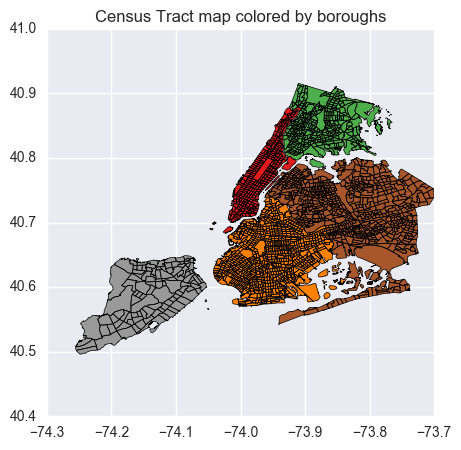

In [2]:
# Loading Census Tract Shape File
shape_path = 'Data/CT_Shape/ct_shape.shp'
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

# Coordinate systems, projections, and transformations
ct_shape.crs  = from_epsg(4326)# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC = ct_shape.to_crs(epsg=2263)# epsg=2263 is US feet
NYC_Area = NYC.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: {:.2f} (mi^2)'.format(NYC_Area) 

# Visualize the Cencus Tract boundaries colored by boroughs
f, ax = pl.subplots(figsize=(5,5))
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
pl.title("Census Tract map colored by boroughs")

<br/>
## 2. Census Data - NYC Population density

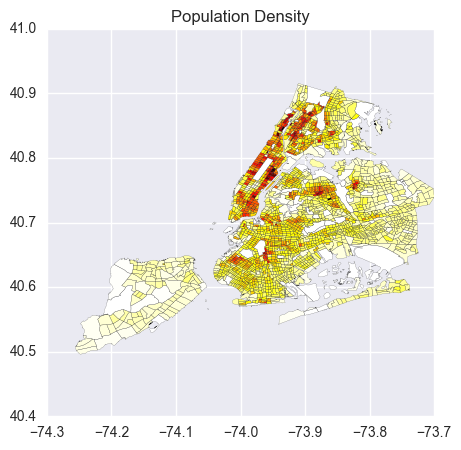

In [4]:
# Load Census Data for 2010
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

# Add popuation density to CT shapefile
#SE_T002_002 is population density in social explorer dataset
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) 

# Vusualize the Population density for 2010
f, ax = pl.subplots(figsize=(5,5))
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
pl.title("Population Density")

<br/>
## 3. CitiBike Data

In [5]:
# Load CitiBike data
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# select summer and winter months
summer_mask = np.in1d(df_bike_monthly.index.month, [6,7,8])
winter_mask = np.in1d(df_bike_monthly.index.month, [12,1,2])

In [23]:
# Summer Data
summer_df_bike_monthly = df_bike_monthly.copy()
summer_df_bike_monthly = summer_df_bike_monthly[summer_mask]
# Winter Data
winter_df_bike_monthly = df_bike_monthly.copy()
winter_df_bike_monthly = winter_df_bike_monthly[winter_mask]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


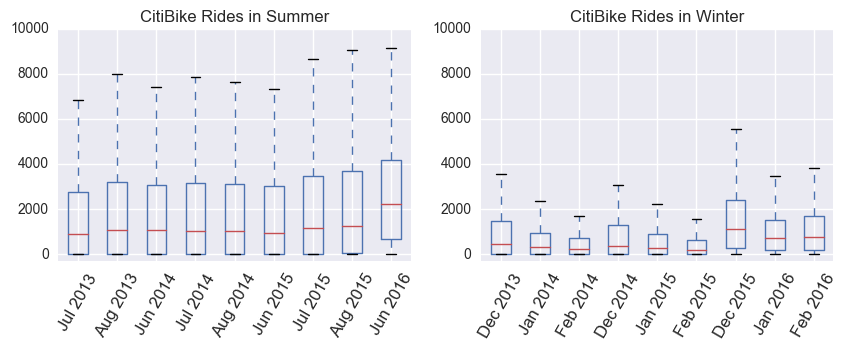

In [37]:
# Time Series Aanalysis
f, (ax1,ax2) = pl.subplots(1,2,figsize=(10,3))

summer_df_bike_monthly_ = summer_df_bike_monthly.copy()
winter_df_bike_monthly_ = winter_df_bike_monthly.copy()
summer_df_bike_monthly_.index = summer_df_bike_monthly_.index.strftime("%b %Y")
winter_df_bike_monthly_.index = winter_df_bike_monthly_.index.strftime("%b %Y")
summer_df_bike_monthly_.T.boxplot(ax=ax1, rot=60, figsize=(5,5))
winter_df_bike_monthly_.T.boxplot(ax=ax2, rot=60, figsize=(5,5))
ax1.set_ylim([-300,10000])
ax2.set_ylim([-300,10000])
ax1.set_title("CitiBike Rides in Summer")
ax2.set_title("CitiBike Rides in Winter")

#### Plots above shows the boxplot of the number of citibike rides in different stations monthly in summer and winter.

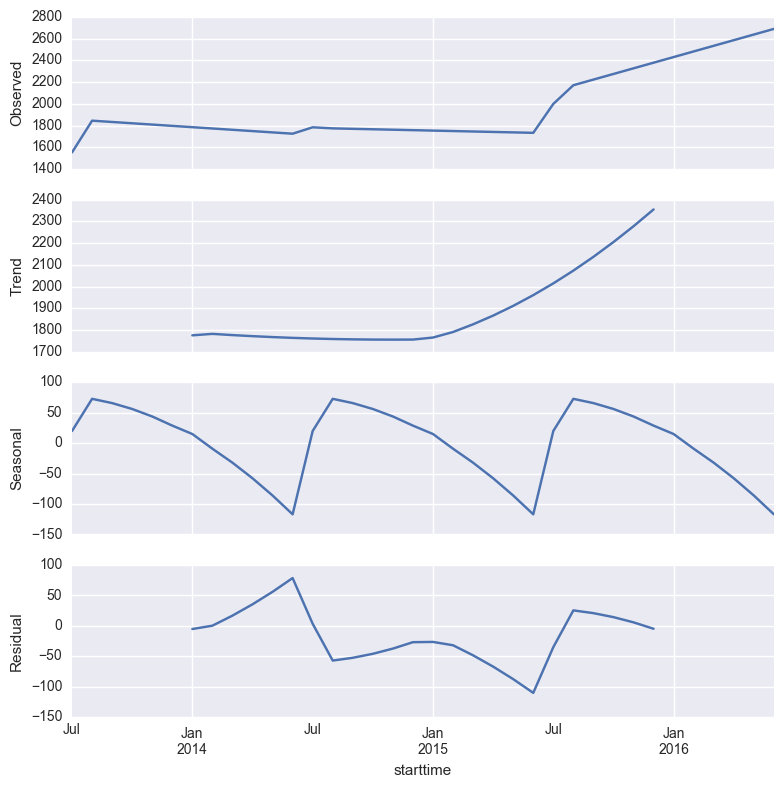

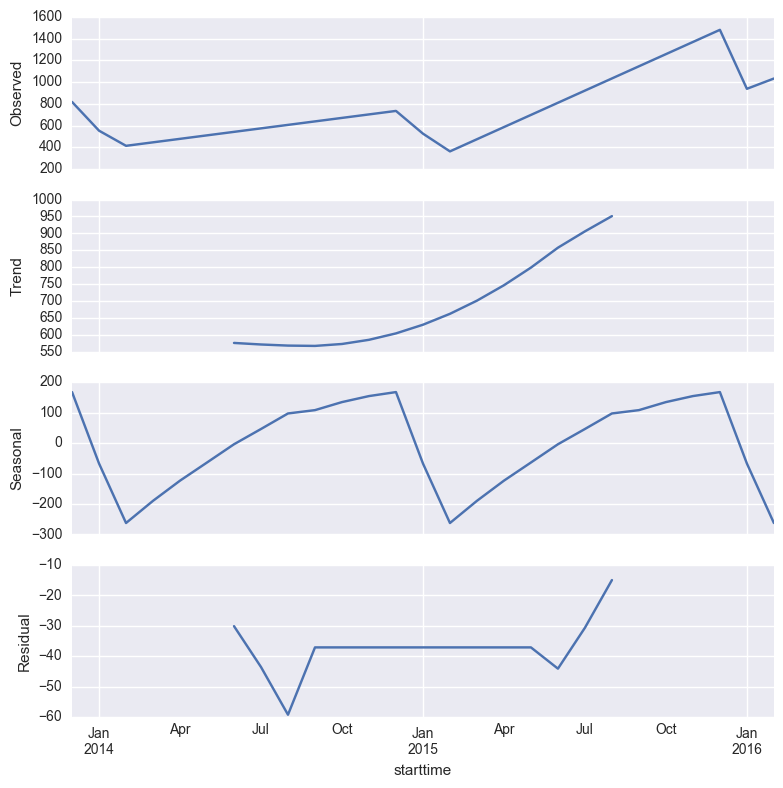

In [40]:
# Seasonal Decomposition

#Create a monthly time series of bike ride (Average of all citibike stations)
summer_df_new = summer_df_bike_monthly.mean(1).resample('M').mean()
summer_df_new.interpolate(inplace=True)
winter_df_new = winter_df_bike_monthly.mean(1).resample('M').mean()
winter_df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
summer_res = sm.tsa.seasonal_decompose(summer_df_new.dropna())
winter_res = sm.tsa.seasonal_decompose(winter_df_new.dropna())
pl.rcParams['figure.figsize']=(8,8)
summer_resplot = summer_res.plot()
winter_resplot = winter_res.plot()

#### Plots above shows the time series analysis of citibike rides in summer and winter.

<br/>
## 4. Map CitiBike Data to CT level

In [59]:
# Load CitiBike station location data
station_id = DataFrame.from_csv('Data/Station_id.csv')
station_id.index = station_id.index.astype(str)
station_id.head()

# Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x: Point(x))
station_id.head()

# Intersect the two geometries
a = []
for i in xrange(station_id.shape[0]):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
    
station_id['BoroCT2010']=a
del station_id['lonlat']

# Add Monthly rides to the station GeoDataFrame with CT code
station_id['summer_MonthlyAve'] = summer_df_bike_monthly.sum(0)
station_id['winter_MonthlyAve'] = winter_df_bike_monthly.sum(0)

# Add the monthly average rides to the CT shapefile
temp = station_id[['summer_MonthlyAve','winter_MonthlyAve']]
temp['station_id'] = station_id.index
temp.index = station_id.BoroCT2010
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0, inplace=True)

print ct_shape_MonthlyAve.shape
ct_shape_MonthlyAve.head()

% 100. (2460, 15)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,summer_MonthlyAve,winter_MonthlyAve,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,14426.0,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,12061.0,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16893.0,10509.0,1329


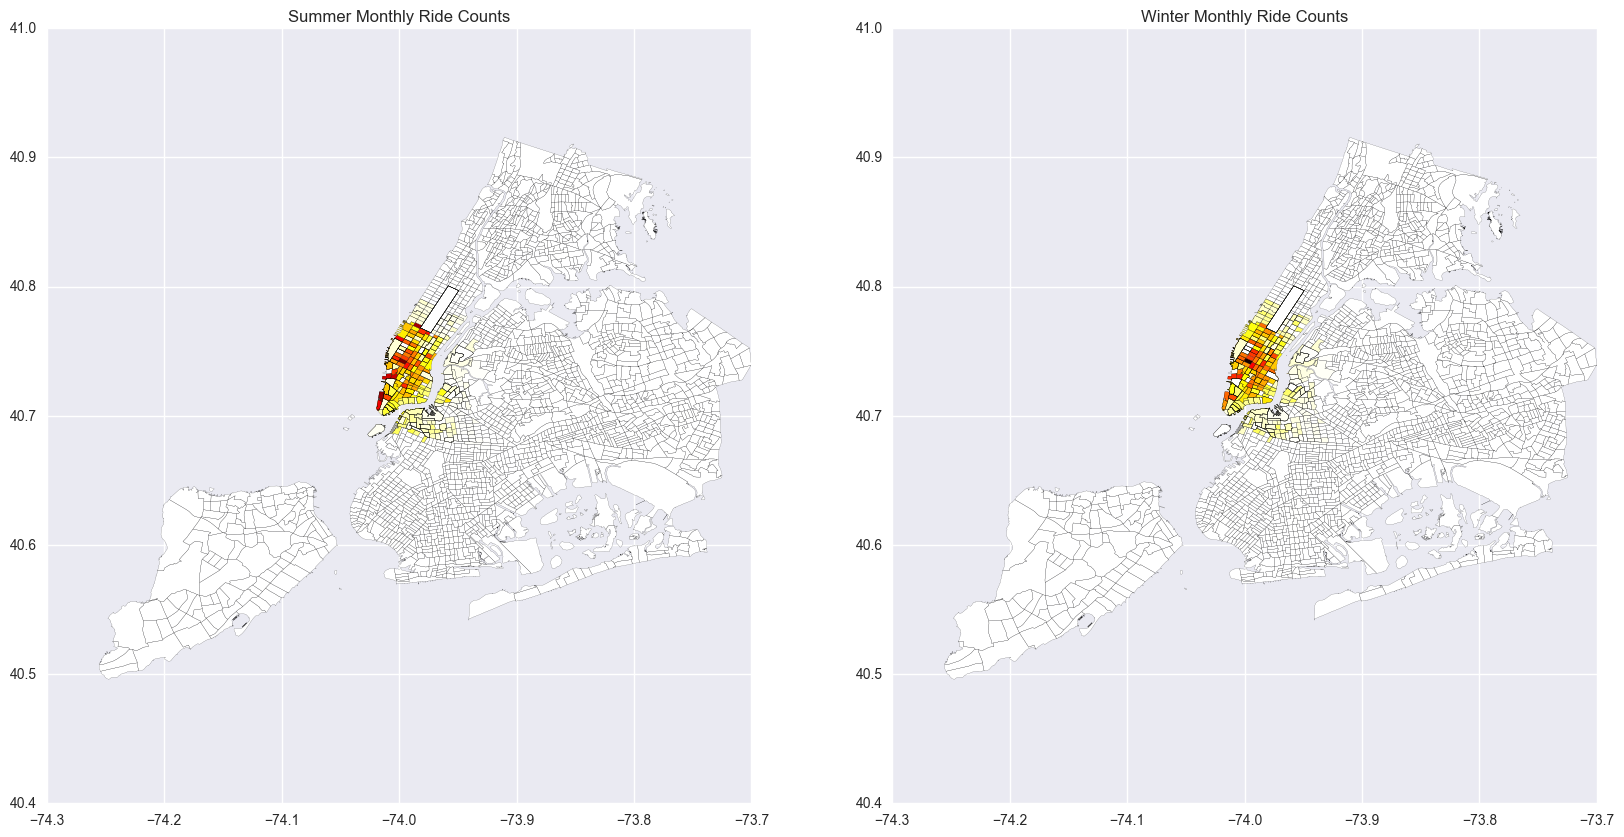

In [63]:
f, (ax1,ax2) = pl.subplots(1, 2, figsize=(20, 10))
ct_shape_MonthlyAve.plot(column='summer_MonthlyAve', colormap='hot_r', linewidth=0.1, ax=ax1, alpha=1)
ax1.set_title("Summer Monthly Ride Counts")
ct_shape_MonthlyAve.plot(column='winter_MonthlyAve', colormap='hot_r', linewidth=0.1, ax=ax2, alpha=1)
ax2.set_title("Winter Monthly Ride Counts")

#### Plots above shows the summer and winter citibike rides in census tract level.

##### ? There's a question since there might be more than one station in one certain CT, the color of the CT in map is not the sum of all station rides, it's only the last station's data.

##### ? I think here we need to groupby CT and apply sum() to averaged rides.

In [71]:
ct_shape_MonthlyAve[np.in1d(ct_shape_MonthlyAve.station_id, ['1197','1229','1329'])]

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,summer_MonthlyAve,winter_MonthlyAve,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,14426.0,3670.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,12061.0,5705.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,16893.0,10509.0,1329


Total number of CTs: 2166
Number of zoomed CTs: 502


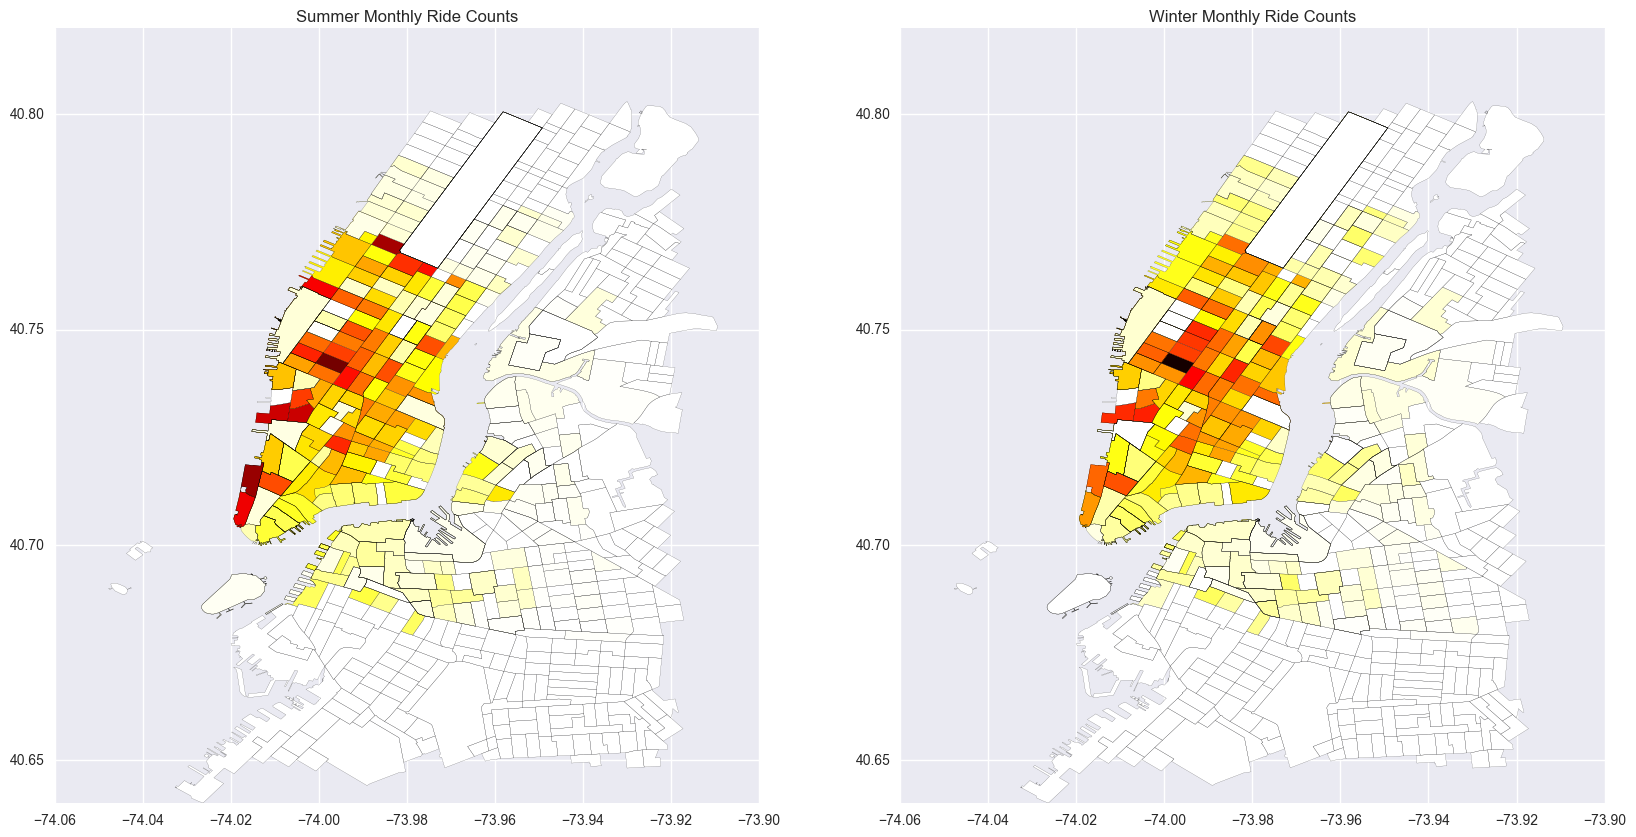

In [74]:
# Removing the CTs that are out of zoom boundries
ct_shape_MonthlyAve_Zoom = ct_shape_MonthlyAve[ct_shape_MonthlyAve.centroid.apply( \
        lambda c: c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)]
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(np.unique(ct_shape_MonthlyAve_Zoom.index))

f, (ax1,ax2) = pl.subplots(1, 2, figsize=(20, 10))
ct_shape_MonthlyAve_Zoom.plot(column='summer_MonthlyAve', colormap='hot_r', linewidth=0.1, ax=ax1, alpha=1)
ax1.set_title("Summer Monthly Ride Counts")
ct_shape_MonthlyAve_Zoom.plot(column='winter_MonthlyAve', colormap='hot_r', linewidth=0.1, ax=ax2, alpha=1)
ax2.set_title("Winter Monthly Ride Counts")

#### Zoom-in plots above shows the summer and winter citibike rides in census tract level.

In [75]:
#Export Shapefile CTs in the CitiBike Zone
path='Output/ct_shape_MonthlyAve_Zoom_2.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

<br/>
## 5. Exploratory Geospatial Analysis

In [76]:
# Spatial Weights
# Contiguity: Queen Weights
qW_CT=ps.queen_from_shapefile(path)

#Number of neighbors for each observation.
qW_CT.cardinalities[10]
qW_CT[10]

#first element being the full numpy array and second element
#keys being the ids associated with each row in the array.
Wmatrix, ids = qW_CT.full()
print Wmatrix.shape, len(ids)

# Change the matrix to be row-standardized
qW_CT.transform ='r'

('Island id: ', [0])
(796, 796) 796
('WARNING: ', 0, ' is an island (no neighbors)')


### 5.1 Spatial Lag
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag=∑_{j}w_{i,j}BikeRideCount$$
 

In [77]:
summer_MonthlyRide=ct_shape_MonthlyAve_Zoom.summer_MonthlyAve # groupby ?
winter_MonthlyRide=ct_shape_MonthlyAve_Zoom.winter_MonthlyAve # groupby ?
summer_MonthlyRideLag=ps.lag_spatial(qW_CT, summer_MonthlyRide) 
winter_MonthlyRideLag=ps.lag_spatial(qW_CT,winter_MonthlyRide)

# Create Quantiles for maping
summer_MonthlyRideLagQ10 =ps.Quantiles(summer_MonthlyRideLag, k=10)
print summer_MonthlyRideLagQ10
winter_MonthlyRideLagQ10 =ps.Quantiles(winter_MonthlyRideLag, k=10)
print winter_MonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80
                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237       

##### ? same question: onc CT may has several stations, which the latter one will replace the former one.

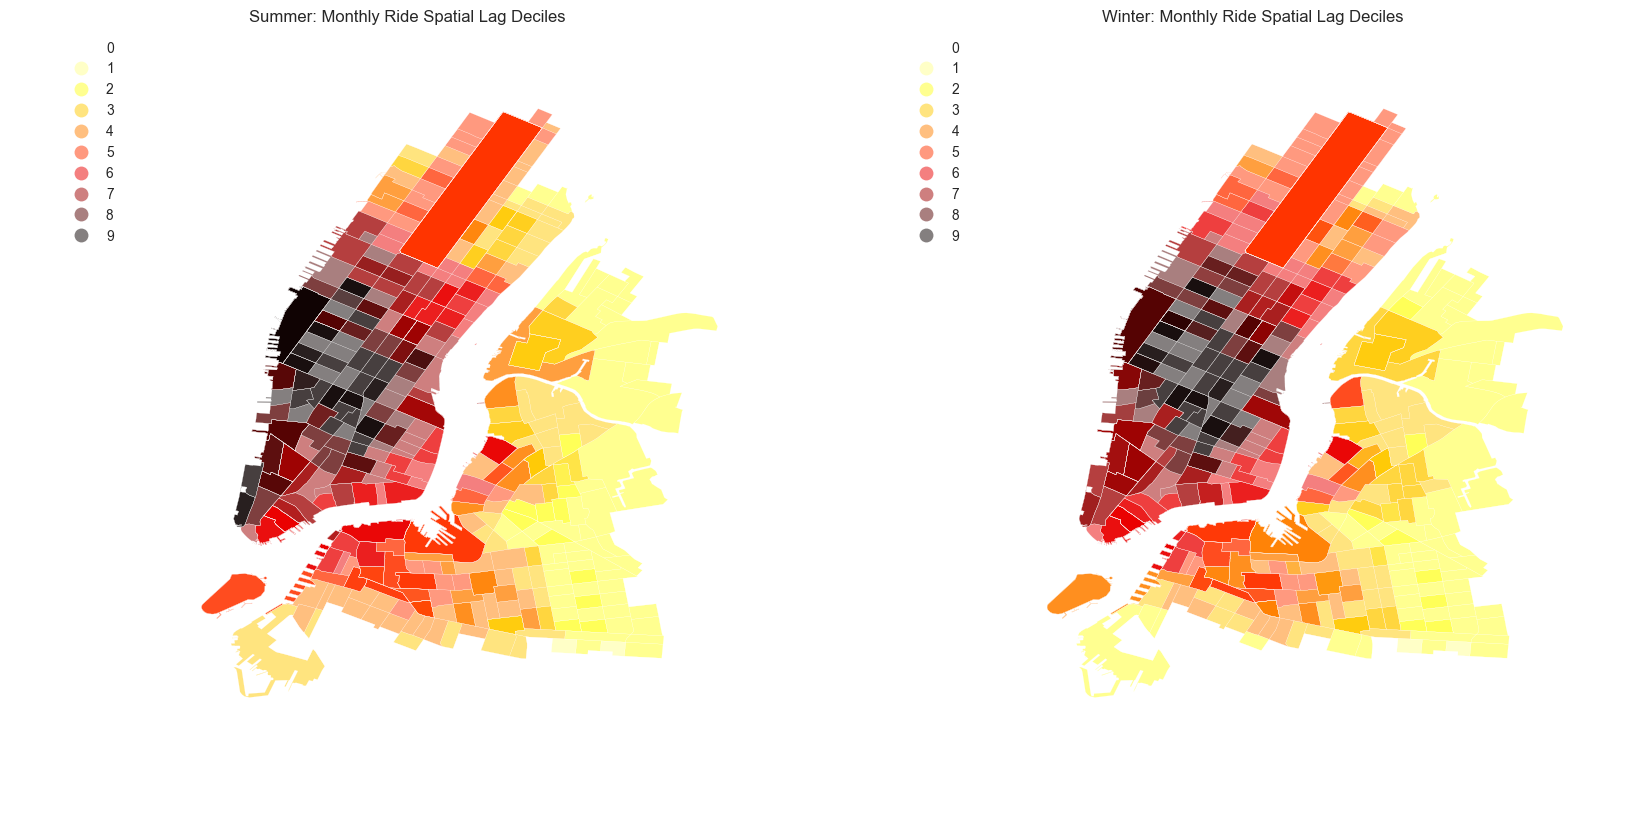

In [79]:
# Map the monthly rides lag
# MonthlyRideLagQ10.yb
f, (ax1,ax2) = pl.subplots(1, 2, figsize = (20,10))
#Assign new columns to a DataFrame, returning a new object
#(a copy) with all the original columns in addition to the new ones.
ct_shape_MonthlyAve_Zoom.assign(cl1=summer_MonthlyRideLagQ10.yb).plot(ax=ax1, column='cl1', \
                                                              categorical=True, k=10, cmap='hot_r',
                                                             edgecolor='white', legend=True, linewidth=0.1)
ax1.set_axis_off()
ax1.set_title("Summer: Monthly Ride Spatial Lag Deciles")
ct_shape_MonthlyAve_Zoom.assign(cl2=winter_MonthlyRideLagQ10.yb).plot(ax=ax2, column='cl2', \
                                                              categorical=True, k=10, cmap='hot_r',
                                                             edgecolor='white', legend=True, linewidth=0.1)
ax2.set_axis_off()
ax2.set_title("Winter: Monthly Ride Spatial Lag Deciles")

#### Plots above shows the Monthly Ride Spatial Lag of each station in Summer and Winter. The deeper colors represents people use citibike stations around that CTs area more frequently. 
#### Based on the observation of the maps, colors of CTs along the Hudson River are lighter than their conterparts in Summer. One possiable explanation is people are less likely to use citibike in winter to ride along the river since it's much colder than inland parts.

### 5.2 Global Spatial Autocorrelation

In [80]:
summer_b, summer_a = np.polyfit(summer_MonthlyRide, summer_MonthlyRideLag, 1)
summer_b, summer_a 

(0.64335490815356466, 4220.5552980795565)

In [81]:
winter_b, winter_a = np.polyfit(winter_MonthlyRide, winter_MonthlyRideLag, 1)
winter_b, winter_a 

(0.66023249858156818, 1600.832423867585)

### Moran Scatterplot

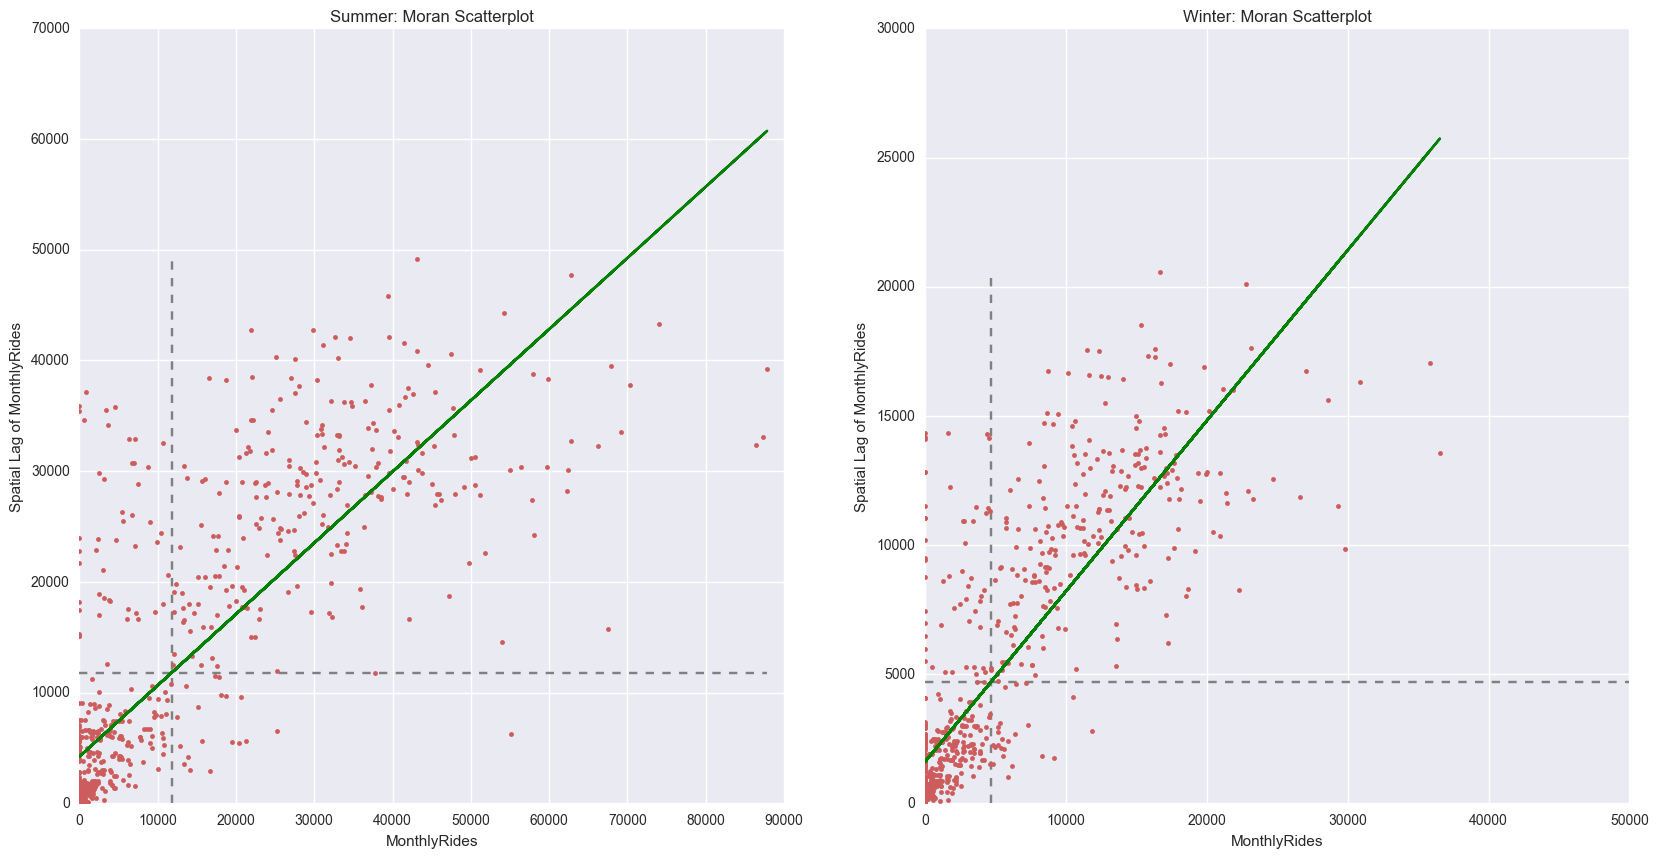

In [88]:
f, (ax1,ax2)= pl.subplots(1, 2, figsize=(20,10))
ax1.plot(summer_MonthlyRide, summer_MonthlyRideLag, '.', color='indianred')
ax1.vlines(summer_MonthlyRide.mean(), summer_MonthlyRideLag.min(), \
           summer_MonthlyRideLag.max(), linestyle='--', color='grey')
ax1.hlines(summer_MonthlyRideLag.mean(), summer_MonthlyRide.min(), \
           summer_MonthlyRide.max(), linestyle='--', color='grey')
ax1.plot(summer_MonthlyRide, summer_a+summer_b*summer_MonthlyRide, 'green')
ax1.set_title('Summer: Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of MonthlyRides')
ax1.set_xlabel('MonthlyRides')

ax2.plot(winter_MonthlyRide, winter_MonthlyRideLag, '.', color='indianred')
ax2.vlines(winter_MonthlyRide.mean(), winter_MonthlyRideLag.min(), \
           winter_MonthlyRideLag.max(), linestyle='--', color='grey')
ax2.hlines(winter_MonthlyRideLag.mean(), winter_MonthlyRide.min(), \
           summer_MonthlyRide.max(), linestyle='--', color='grey')
ax2.plot(winter_MonthlyRide, winter_a+winter_b*winter_MonthlyRide, 'green')
ax2.set_title('Winter: Moran Scatterplot')
ax2.set_ylabel('Spatial Lag of MonthlyRides')
ax2.set_xlim(0,50000)
ax2.set_xlabel('MonthlyRides')

#### Plots above shows the relationship between stations' rides and their spatial lag rides. 

### Moran's I

In [98]:
# summer_MonthlyRide.groupby(summer_MonthlyRide.index).apply(sum)
# Here whether groupby or not will lead to different interpretations but both are meaningful.

In [100]:
summer_I_MonthlyRide = ps.Moran(summer_MonthlyRide, qW_CT)
summer_I_MonthlyRide.I, summer_I_MonthlyRide.p_sim

(0.64353398667011008, 0.001)

In [102]:
winter_I_MonthlyRide = ps.Moran(winter_MonthlyRide, qW_CT)
winter_I_MonthlyRide.I, winter_I_MonthlyRide.p_sim

(0.66039156431885593, 0.001)

<br/>
### KDE plot of all of the simulated points

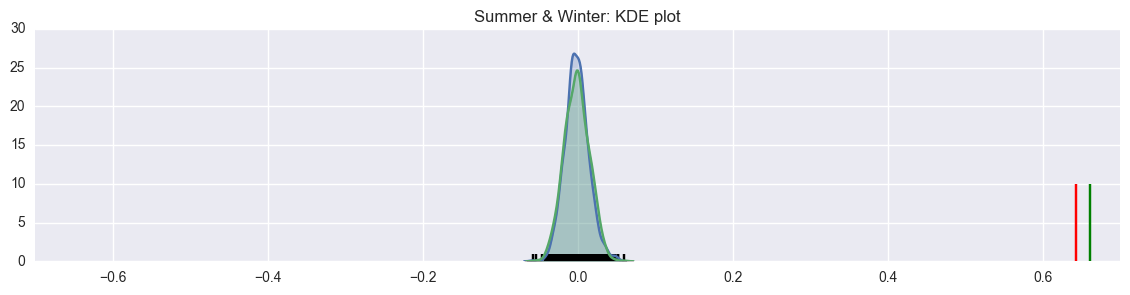

In [108]:
#the vertical line shows the observed value
pl.rcParams['figure.figsize']=(14,3)
sns.kdeplot(summer_I_MonthlyRide.sim, shade=True)
pl.vlines(summer_I_MonthlyRide.sim, 0, 1) # black line below the bell
pl.vlines(summer_I_MonthlyRide.I, 0, 10, 'r') 
pl.xlim([-.70, .70])
pl.title('Summer: KDE plot')

sns.kdeplot(winter_I_MonthlyRide.sim, shade=True)
pl.vlines(winter_I_MonthlyRide.sim, 0, 1) # black line below the bell
pl.vlines(winter_I_MonthlyRide.I, 0, 10, 'g') 
pl.xlim([-.70, .70])
pl.title('Summer & Winter: KDE plot')

#### Plots below shows the KDE plots for rides in each summer and winter months respectively.  The vertical lines show the observed Maron I values

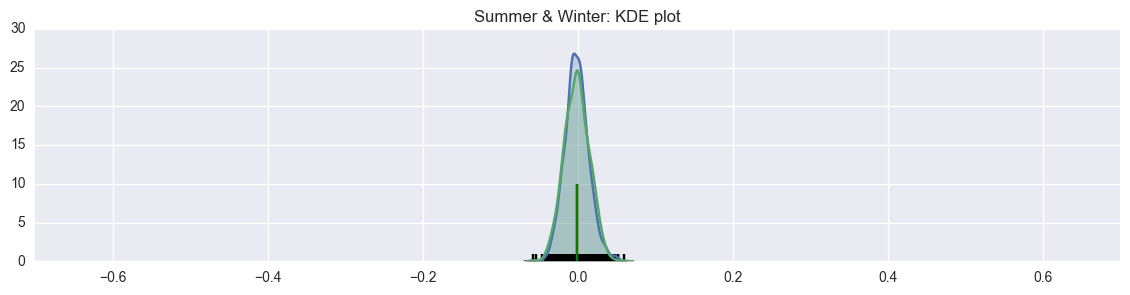

In [109]:
pl.rcParams['figure.figsize']=(14,3)
sns.kdeplot(summer_I_MonthlyRide.sim, shade=True)
pl.vlines(summer_I_MonthlyRide.sim, 0, 1) # black line below the bell
pl.vlines(summer_I_MonthlyRide.EI, 0, 10, 'r') 
pl.xlim([-.70, .70])
pl.title('Summer: KDE plot')

sns.kdeplot(winter_I_MonthlyRide.sim, shade=True)
pl.vlines(winter_I_MonthlyRide.sim, 0, 1) # black line below the bell
pl.vlines(winter_I_MonthlyRide.EI, 0, 10, 'g') 
pl.xlim([-.70, .70])
pl.title('Summer & Winter: KDE plot')

#### Plots below shows the KDE plots for rides in each summer and winter months respectively.  The vertical lines show the observed Maron EI values

<br/>
### Local Spatial Autocorrelation

In [110]:
summer_LMo_MonthlyRide = ps.Moran_Local(summer_MonthlyRide, qW_CT, permutations=999)
winter_LMo_MonthlyRide = ps.Moran_Local(winter_MonthlyRide, qW_CT, permutations=999)

In [111]:
summer_LMo_MonthlyRide.Is[0:5], summer_LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.2391325 ,  0.01474643,  0.00173718,  0.02473794]),
 array([ 0.001,  0.186,  0.359,  0.338,  0.39 ]))

In [112]:
winter_LMo_MonthlyRide.Is[0:5], winter_LMo_MonthlyRide.p_sim[0:5]

(array([ -0.00000000e+00,  -3.14119985e-01,  -1.93084894e-04,
         -4.03594530e-03,  -7.97531288e-02]),
 array([ 0.001,  0.128,  0.471,  0.478,  0.417]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [114]:
summer_sigs = summer_MonthlyRide[summer_LMo_MonthlyRide.p_sim <= .005] #Local Spatial Autocorrelation
summer_W_sigs = summer_MonthlyRideLag[summer_LMo_MonthlyRide.p_sim <= .005]
summer_insigs = summer_MonthlyRide[summer_LMo_MonthlyRide.p_sim > .005]
summer_W_insigs = summer_MonthlyRideLag[summer_LMo_MonthlyRide.p_sim > .005]

winter_sigs = winter_MonthlyRide[winter_LMo_MonthlyRide.p_sim <= .005]
winter_W_sigs = winter_MonthlyRideLag[winter_LMo_MonthlyRide.p_sim <= .005]
winter_insigs = winter_MonthlyRide[winter_LMo_MonthlyRide.p_sim > .005]
winter_W_insigs = winter_MonthlyRideLag[winter_LMo_MonthlyRide.p_sim > .005]

##### The meaning of red line is not understood, why global I, it's pearson's correlation coef

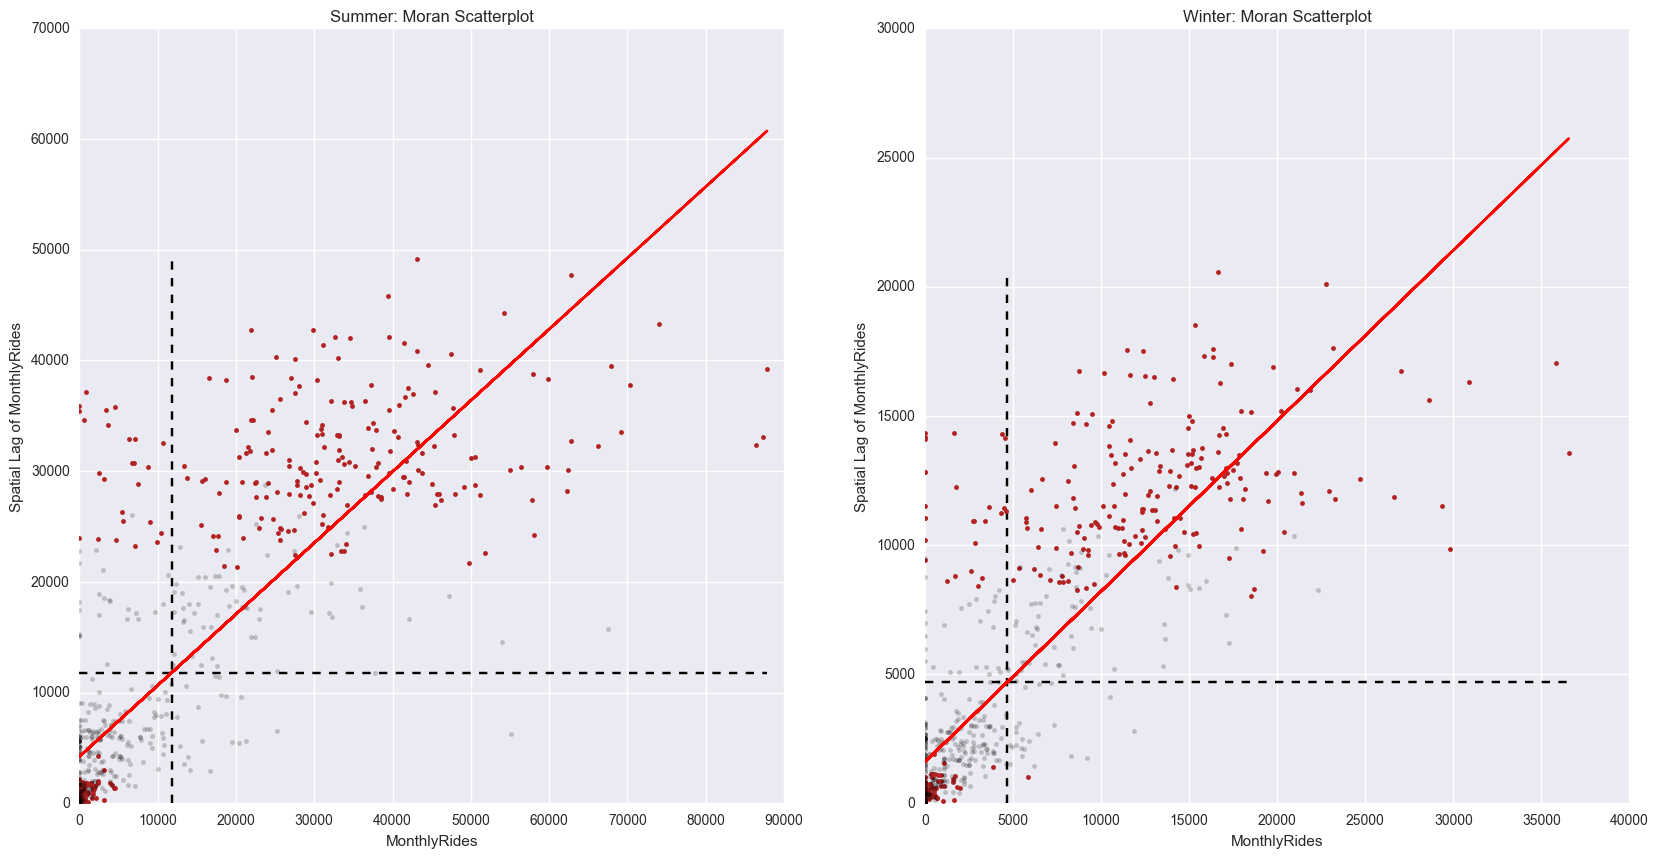

In [121]:
#Plot Signficant LISA
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(summer_sigs, summer_W_sigs, '.', color='firebrick')
ax1.plot(summer_insigs, summer_W_insigs, '.k', alpha=.2)
#ax1.text(s='$I = %.3f$' % summer_I_MonthlyRide.I, x=120000, y=5000, fontsize=18)
ax1.vlines(summer_MonthlyRide.mean(), summer_MonthlyRideLag.min(), summer_MonthlyRideLag.max(), linestyle='--')
ax1.hlines(summer_MonthlyRideLag.mean(), summer_MonthlyRide.min(), summer_MonthlyRide.max(), linestyle='--')
# red line of best fit using global I as slope  ??????
ax1.plot(summer_MonthlyRide, summer_a + summer_b*summer_MonthlyRide, 'r')
ax1.set_title('Summer: Moran Scatterplot')
ax1.set_ylabel('Spatial Lag of MonthlyRides')
ax1.set_xlabel('MonthlyRides')

ax2.plot(winter_sigs, winter_W_sigs, '.', color='firebrick')
ax2.plot(winter_insigs, winter_W_insigs, '.k', alpha=.2)
#ax2.text(s='$I = %.3f$' % winter_I_MonthlyRide.I, x=120000, y=5000, fontsize=18)
ax2.vlines(winter_MonthlyRide.mean(), winter_MonthlyRideLag.min(), winter_MonthlyRideLag.max(), linestyle='--')
ax2.hlines(winter_MonthlyRideLag.mean(), winter_MonthlyRide.min(), winter_MonthlyRide.max(), linestyle='--')
ax2.plot(winter_MonthlyRide, winter_a + winter_b*winter_MonthlyRide, 'r')
ax2.set_title('Winter: Moran Scatterplot')
ax2.set_ylabel('Spatial Lag of MonthlyRides')
ax2.set_xlabel('MonthlyRides')

#### Plots above show the relationship between Monthly rides and Spatial Lag rides. The Red points represent they are locally spatial autocorrelated.

### Hot and Cold spots

In [124]:
summer_sig = summer_LMo_MonthlyRide.p_sim < 0.005
summer_hotspots = summer_LMo_MonthlyRide.q==1 * summer_sig #HH
summer_coldspots = summer_LMo_MonthlyRide.q==3 * summer_sig #LL
print "Number of Hotspots in Summer:", summer_hotspots.sum()
print "Number of Coldspots in Sumemer:", summer_coldspots.sum()

winter_sig = winter_LMo_MonthlyRide.p_sim < 0.005
winter_hotspots = winter_LMo_MonthlyRide.q==1 * winter_sig #HH
winter_coldspots = winter_LMo_MonthlyRide.q==3 * winter_sig #LL
print "Number of Hotspots in Winter:", winter_hotspots.sum()
print "Number of Coldspots in Winter:", winter_coldspots.sum()

Number of Hotspots in Summer: 184
Number of Coldspots in Sumemer: 179
Number of Hotspots in Winter: 173
Number of Coldspots in Winter: 136


##### Hot Spots represente those stations with High rides, High spatial lag rides (HH) and locally spatial-autocorrelated pattern.
##### Cold Spots represente those stations with Low rides , Low spatial lag rides (LL) are locally spatial-autocorrelated pattern.


#### same problems: replacemnt... but still meaning. for example, when calculate I, use the same weight twice.

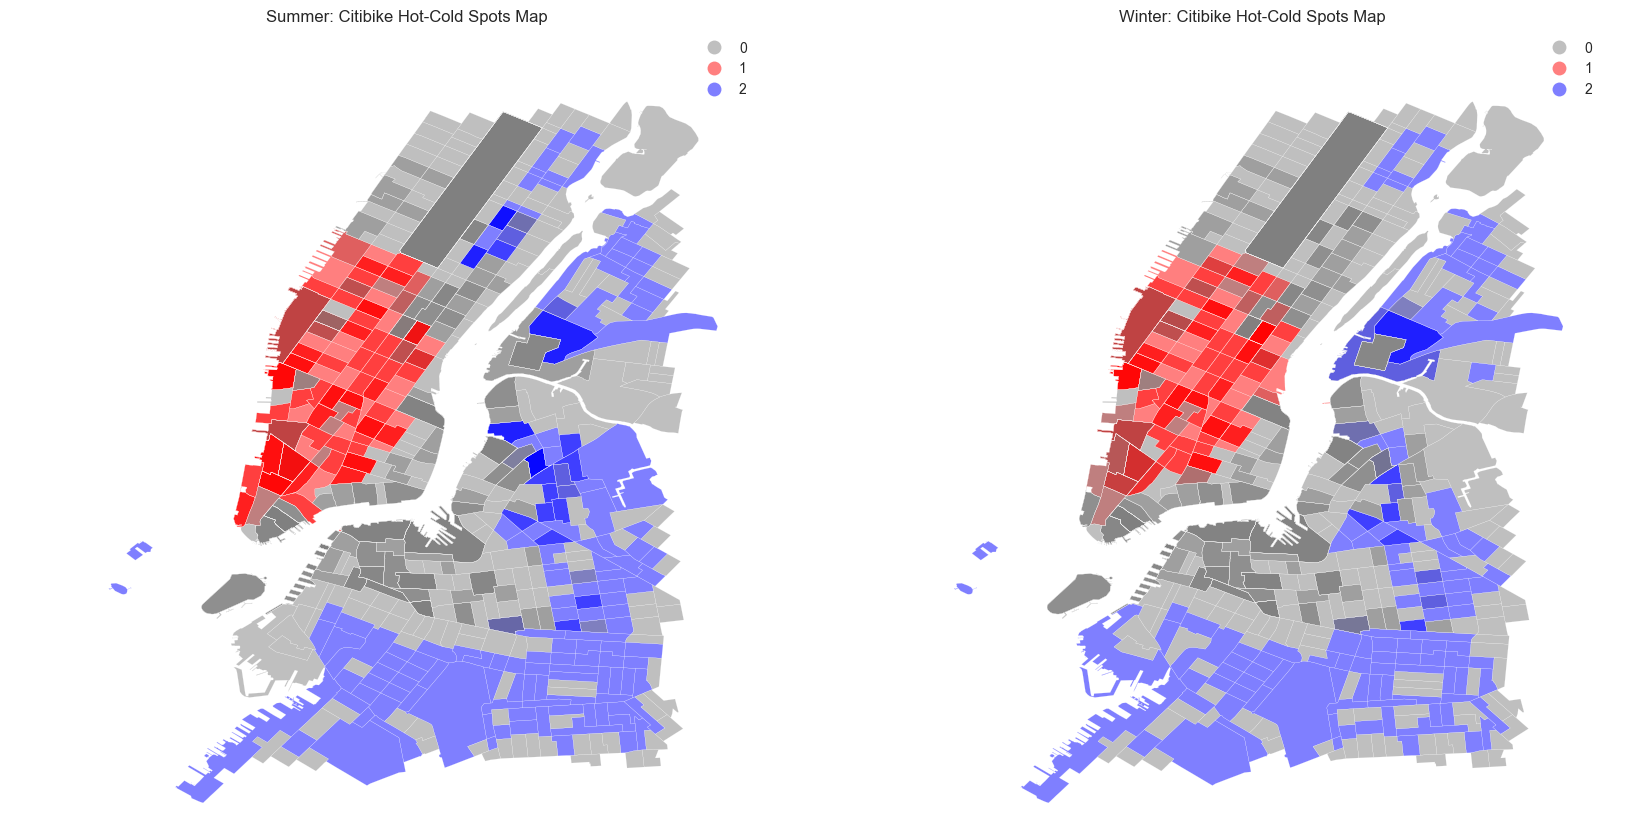

In [129]:
hcmap = colors.ListedColormap(['grey','red','blue'])
summer_hotcold = summer_hotspots*1 + summer_coldspots*2
winter_hotcold = winter_hotspots*1 + winter_coldspots*2
f, (ax1,ax2) = pl.subplots(1, 2, figsize=(20, 10))
ct_shape_MonthlyAve_Zoom.assign(c1=summer_hotcold).plot(column='c1', categorical=True, 
                                                              cmap=hcmap, linewidth=0.1, ax=ax1, 
                                                              edgecolor='white', legend=True)
ax1.set_axis_off()
ax1.set_title("Summer: Citibike Hot-Cold Spots Map")

ct_shape_MonthlyAve_Zoom.assign(c2=winter_hotcold).plot(column='c2', categorical=True, 
                                                              cmap=hcmap, linewidth=0.1, ax=ax2, 
                                                              edgecolor='white', legend=True)
ax2.set_axis_off()
ax2.set_title("Winter: Citibike Hot-Cold Spots Map")

#### Plots above show the hot-cold spots map in summer and winter. According to observation of these maps, there're several evident differences between them. One is that in summer Mid-East zone shows LL with local spatial autocorrelated pattern. The other is that East Lower Manhattan along East River shows much less local spatial autocorrelated pattern in winter compared with their conterparts in summer. 